# Distinguising Supersymmetric Particles from Background

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Load and Split the Data

Write a function `load_and_split_data(filename, train_ratio=0.7)` whose functionality is to load and split the data
for a specific ratio of train and validation data (we won't use a third test dataset for now, which we would need to make a final assessment)

In [90]:
def load_and_split_data(filename, train_ratio=0.7):
    data = pd.read_csv(filename).to_numpy()
    maxidx = int(len(data) * train_ratio)
    train_data = data[:maxidx]
    valid_data = data[maxidx:]
    return train_data, valid_data

def make_data(dataset, N = 100):
    dataX, datay = dataset[:,1:], dataset[:,:1]
    idx = np.random.choice(np.arange(len(dataX)), size = N, replace=True)
    return torch.FloatTensor(dataX[idx]), torch.FloatTensor(datay[idx])

In [96]:
train_data, valid_data = load_and_split_data('SUSY_small.csv',0.7)

## Visualize the Dataset

It's always good to visualize the data before starting to do crazy machine learning with it. This is
sometimes referred to as exploratory data analysis (EDA) and is useful to catch e.g. vastly diverging
scales between features

Visualize the 18 data features on 18 panels, where on each panel you have two histograms
* the distribution of the feature for y == 0
* the distribution of the feature for y == 1

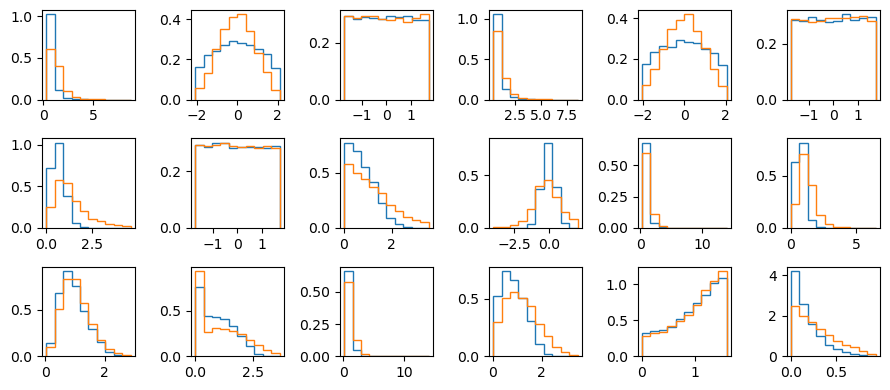

In [97]:
def plot_dataset(axarr,dataset):
    dataX, datay = dataset[:,1:], dataset[:,:1]
    for idx,ax in enumerate(axarr.ravel()[:data.shape[1]]):
        _,bins,_ = ax.hist(dataX[datay[:,0]==0,idx], histtype = 'step', density = True)
        _,bins,_ = ax.hist(dataX[datay[:,0]==1,idx], bins = bins, histtype = 'step', density = True)
f,axarr = plt.subplots(3,6)
plot_dataset(axarr,train_data)
f.set_size_inches(9,4)
f.set_tight_layout(True)

## Create a function that creates a simple MLP

The neural network should have width N hidden layers and use ReLU activations internally and finish up with a sigmoid activation


In [98]:
def make_model(N = 512):
    net = torch.nn.Sequential(
        torch.nn.Linear(18,N),
        torch.nn.ReLU(),
        torch.nn.Linear(N,N),
        torch.nn.ReLU(),
        torch.nn.Linear(N,1),
        torch.nn.Sigmoid()
    )
    return net

## Create a Training Loop



In [99]:
def train(train_data):
    net = make_model()
    opt = torch.optim.Adam(net.parameters(),1e-3)
    traj = []
    for i in range(3000):
        X,Y = make_data(train_data, 1000)
        p = net(X)
        train_loss = torch.nn.functional.binary_cross_entropy(p,Y)
        train_loss.backward()
        opt.step()
        opt.zero_grad()

        traj.append(float(train_loss))
        if i % 100  == 0:
            print(f'step: {i} loss: {float(train_loss):.3f}')
    traj = np.array(traj)
    return net, traj

## Train the Model

step: 0 loss: 0.699
step: 100 loss: 0.424
step: 200 loss: 0.473
step: 300 loss: 0.417
step: 400 loss: 0.417
step: 500 loss: 0.418
step: 600 loss: 0.392
step: 700 loss: 0.392
step: 800 loss: 0.398
step: 900 loss: 0.393
step: 1000 loss: 0.425
step: 1100 loss: 0.391
step: 1200 loss: 0.390
step: 1300 loss: 0.344
step: 1400 loss: 0.377
step: 1500 loss: 0.361
step: 1600 loss: 0.380
step: 1700 loss: 0.335
step: 1800 loss: 0.319
step: 1900 loss: 0.309
step: 2000 loss: 0.345
step: 2100 loss: 0.320
step: 2200 loss: 0.319
step: 2300 loss: 0.306
step: 2400 loss: 0.318
step: 2500 loss: 0.295
step: 2600 loss: 0.274
step: 2700 loss: 0.272
step: 2800 loss: 0.252
step: 2900 loss: 0.275


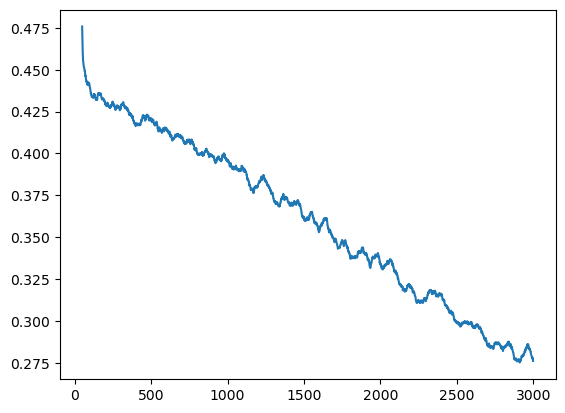

In [100]:
net, traj = train(train_data)
plt.plot(pd.Series(traj).rolling(50).mean())

## Wait a minute - Evaluate the True Performance

In [102]:
def eval_model(net, data):
    with torch.no_grad():
        X,Y = make_data(data, 1000)
        p = net(X)
        loss = torch.nn.functional.binary_cross_entropy(p,Y)
    return loss

In [103]:
eval_model(net, valid_data)

tensor(0.5888)

## 👀 - seems like we can't trust the train performance

Write an improved training loop that also tracks the validation performance

step: 0 loss: 0.694
step: 100 loss: 0.443
step: 200 loss: 0.416
step: 300 loss: 0.413
step: 400 loss: 0.425
step: 500 loss: 0.414
step: 600 loss: 0.411
step: 700 loss: 0.417
step: 800 loss: 0.383
step: 900 loss: 0.421
step: 1000 loss: 0.396
step: 1100 loss: 0.408
step: 1200 loss: 0.367
step: 1300 loss: 0.392
step: 1400 loss: 0.367
step: 1500 loss: 0.395
step: 1600 loss: 0.381
step: 1700 loss: 0.336
step: 1800 loss: 0.329
step: 1900 loss: 0.326
step: 2000 loss: 0.330
step: 2100 loss: 0.342
step: 2200 loss: 0.316
step: 2300 loss: 0.317
step: 2400 loss: 0.310
step: 2500 loss: 0.340
step: 2600 loss: 0.293
step: 2700 loss: 0.291
step: 2800 loss: 0.276
step: 2900 loss: 0.308


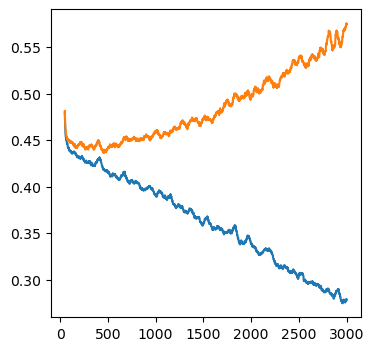

In [104]:
def train(train_data, test_data):
    net = make_model()
    opt = torch.optim.Adam(net.parameters(),1e-3)
    traj = []
    for i in range(3000):
        X,Y = make_data(train_data, 1000)
        p = net(X)
        train_loss = torch.nn.functional.binary_cross_entropy(p,Y)
        train_loss.backward()
        opt.step()
        opt.zero_grad()

        test_loss = eval_model(net, test_data)



        traj.append([float(train_loss), float(test_loss)])
        if i % 100  == 0:
            print(f'step: {i} loss: {float(train_loss):.3f}')
    traj = np.array(traj)
    return net, traj

net, traj = train(train_data, test_data)
plt.plot(pd.Series(traj[:,0]).rolling(50).mean())
plt.plot(pd.Series(traj[:,1]).rolling(50).mean())
plt.gcf().set_size_inches(4,4)

## Getting the ROC curve

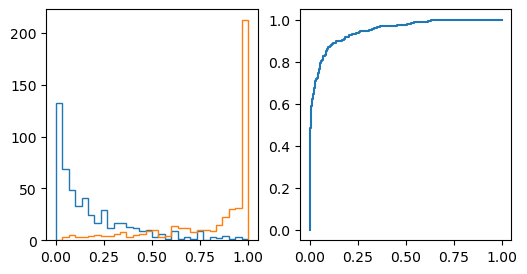

In [106]:
import sklearn.metrics as metrics
def plot_distribution(dataset, model):
    f, axarr = plt.subplots(1,2)
    f.set_size_inches(6,3)
    X,Y = make_data(dataset, 1000)
    with torch.no_grad():
        p = net(X)
    bins = np.linspace(0,1,31)
    ax = axarr[0]
    ax.hist(p[Y==0], histtype = 'step', bins = bins)
    ax.hist(p[Y==1], histtype = 'step', bins = bins)
    
    ax = axarr[1]
    a,b,c = metrics.roc_curve(Y,p)
    ax.plot(a,b)

plot_distribution(train_data, net)